### Demonstration of matrix-factorization based collaborative filtering recommender

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The inital ratings matrix.  "0" indicates an unrated item.  Item ratings from from 1-5.

In [2]:
def ratings_matrix():
    """ Sets initial ratings matrix with items ranked 1-5. 
        
        Rows are users, columns are items. Unrated items
        have 0 values.
        
        Parameters
        ----------
        None
        Returns
        -------
        2d numpy array of type float
    """ 
    return np.array([[4, 4, 0, 2, 2],
                     [4, 0, 0, 3, 3],
                     [4, 0, 0, 1, 1],
                     [1, 1, 1, 2, 0],
                     [2, 2, 2, 0, 0],
                     [1, 1, 1, 0, 0],
                     [5, 5, 5, 0, 0]]).astype(float)

In [3]:
R = ratings_matrix()
print(R)

[[4. 4. 0. 2. 2.]
 [4. 0. 0. 3. 3.]
 [4. 0. 0. 1. 1.]
 [1. 1. 1. 2. 0.]
 [2. 2. 2. 0. 0.]
 [1. 1. 1. 0. 0.]
 [5. 5. 5. 0. 0.]]


### Try to use NMF to predict ratings

In [4]:
from sklearn.decomposition import NMF

In [5]:
# try one value for k
k = 2
model = NMF(n_components=k, init='random', random_state=0)
U = model.fit_transform(R)
V = model.components_
R_recon = np.dot(U,V)
print("Number of latent factors: {0}".format(k))
print("Original ratings matrix:")
print(R.round(1))
print("\nReconstructed ratings matrix:")
print(R_recon.round(1))
# now try 5 -  what does the reconstructed matrix look like?

Number of latent factors: 2
Original ratings matrix:
[[4. 4. 0. 2. 2.]
 [4. 0. 0. 3. 3.]
 [4. 0. 0. 1. 1.]
 [1. 1. 1. 2. 0.]
 [2. 2. 2. 0. 0.]
 [1. 1. 1. 0. 0.]
 [5. 5. 5. 0. 0.]]

Reconstructed ratings matrix:
[[4.5 2.3 1.5 2.  1.8]
 [4.2 0.7 0.  2.8 2.6]
 [2.9 0.7 0.2 1.8 1.7]
 [1.6 0.9 0.6 0.6 0.6]
 [1.9 2.2 1.8 0.1 0. ]
 [1.  1.1 0.9 0.  0. ]
 [4.9 5.5 4.6 0.1 0. ]]


### The problem with the above approach is that the code is trying to find latent topics that predict the 0 ratings, too.  0 simply means not-rated; non-zero rating predictions are what we desire in-place of the 0 placeholder.

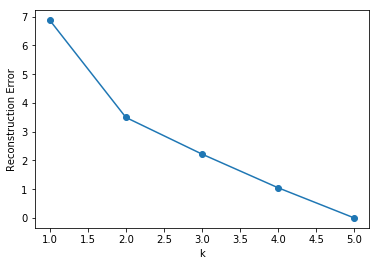

In [6]:
# Look for right value of k
import matplotlib.pyplot as plt

def fit_nmf(k, R):
    nmf = NMF(n_components=k)
    nmf.fit(R)
    U = nmf.transform(R);
    V = nmf.components_;
    return nmf.reconstruction_err_

k_max = 5
error = [fit_nmf(i, R) for i in range(1,k_max+1)]
plt.plot(range(1,k_max+1), error, 'o-')
plt.xlabel('k')
plt.ylabel('Reconstruction Error')
plt.show()

Unsurprisingly, as the number of topics increases to be the number of items, the matrix is perfectly reconstructed (0's and all)

### Code that only updates the matrices where ratings aren't zero
Adapted from [this post.](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)  
Appears to be an implementation of FunkSVD (See Wikipedia "Matrix Factorization for Recommendation Systems")

In [7]:
"""
@INPUT:
    R     : a matrix to be factorized, dimension N x M
    P     : an initial matrix of dimension N x K (think U)
    Q     : an initial matrix of dimension M x K, Q.T is K X M (think V)
    K     : the number of latent features
    steps : the maximum number of steps to perform the optimisation
    alpha : the learning rate
    beta  : the regularization parameter
@OUTPUT:
    the final matrices P and Q
"""
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            print("Converged!")
            break
    return P, Q, e

### Use the function above to factorize the same ratings matrix, investigate reconstruction error associated with the number of latent factors/topics

In [8]:
Ks = [1, 2, 3, 4, 5] # of latent factors
N = len(R) # number of rows in the ratings matrix
M = len(R[0]) # number of columns in the ratings matrix

Pf_k = []
Qf_k = []
err_k = []
for K in Ks:
    P = np.random.rand(N,K) # think U
    Q = np.random.rand(M,K) # think V
    Pf, Qf, error = matrix_factorization(R, P, Q, K)
    Pf_k.append(Pf)
    Qf_k.append(Qf)
    err_k.append(error)
    print("Latent factors: {0}, reconstruction error: {1:0.2f}.".format(K, error))

Latent factors: 1, reconstruction error: 5.89.
Latent factors: 2, reconstruction error: 2.41.
Latent factors: 3, reconstruction error: 1.97.
Latent factors: 4, reconstruction error: 1.61.
Latent factors: 5, reconstruction error: 1.63.


In [9]:
print("Investigate factorized matrices shapes")
for K, Pf, Qf in list(zip(Ks, Pf_k, Qf_k)):
    print("Latent factors: {0}, shape P: {1}, shape Q: {2}".format(K, Pf.shape, Qf.shape))

Investigate factorized matrices shapes
Latent factors: 1, shape P: (7, 1), shape Q: (1, 5)
Latent factors: 2, shape P: (7, 2), shape Q: (2, 5)
Latent factors: 3, shape P: (7, 3), shape Q: (3, 5)
Latent factors: 4, shape P: (7, 4), shape Q: (4, 5)
Latent factors: 5, shape P: (7, 5), shape Q: (5, 5)


In [10]:
# Reconstruction error with 3 topics was the best, diminishing returns with more
K = 3
P = np.random.rand(N,K) # think U
Q = np.random.rand(M,K) # think V
nP, nQ, error = matrix_factorization(R, P, Q, K)
R_recon_mf = np.dot(nP, nQ)

print("Number of latent factors: {0}".format(K))
print("Reconstruction error: {0:0.3f}".format(error))
print("Original ratings matrix:")
print(R.round(1))
print("\nReconstructed ratings matrix:")
print(R_recon_mf.round(1))

Number of latent factors: 3
Reconstruction error: 3.305
Original ratings matrix:
[[4. 4. 0. 2. 2.]
 [4. 0. 0. 3. 3.]
 [4. 0. 0. 1. 1.]
 [1. 1. 1. 2. 0.]
 [2. 2. 2. 0. 0.]
 [1. 1. 1. 0. 0.]
 [5. 5. 5. 0. 0.]]

Reconstructed ratings matrix:
[[4.  4.  4.  1.8 2. ]
 [4.3 3.9 4.  2.9 2.6]
 [3.3 3.3 3.2 1.6 1.6]
 [1.2 0.9 1.1 1.5 1. ]
 [2.  2.  2.  1.  0.9]
 [1.1 0.9 1.  0.9 0.7]
 [5.1 5.  4.9 2.6 2.6]]
